In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image
import numpy as np
from sklearn.metrics import roc_auc_score

# Import your custom modules
from resnet import get_resnet
from network import Network
from transform import Transforms
from contrastive_loss import InstanceLoss, ClusterLoss
from TransMIL import TransMIL

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================
# 2. Define Dataset Class
# ==========================

class WSIDataset(Dataset):
    def __init__(self, data_dir, transform):
        """
        Args:
            data_dir (str): Directory with all the images.
            transform (callable): Transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = self._load_image_paths()

    def _load_image_paths(self):
        supported_formats = ('.png', '.jpg', '.jpeg', '.tif', '.bmp')
        image_paths = [
            os.path.join(self.data_dir, fname)
            for fname in os.listdir(self.data_dir)
            if fname.lower().endswith(supported_formats)
        ]
        if not image_paths:
            raise ValueError(f"No images found in {self.data_dir}. Supported formats: {supported_formats}")
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        x_i, x_j = self.transform(image)
        return x_i, x_j

Using device: cuda


In [3]:
# ==========================
# 3. Initialize Feature Extractor
# ==========================

# Step 1: Feature Extraction using ResNet
feature_extractor = get_resnet("ResNet50")
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  # Set to evaluation mode

# Freeze ResNet parameters to prevent updates during contrastive training
for param in feature_extractor.parameters():
    param.requires_grad = False

print("Feature extractor initialized and frozen.")


Feature extractor initialized and frozen.


In [4]:
assert hasattr(feature_extractor, 'rep_dim'), "ResNet model must have 'rep_dim' attribute defined."

contrastive_network = Network(resnet=feature_extractor, feature_dim=264, class_num=2)
contrastive_network = contrastive_network.to(device)
contrastive_network.train()  # Set to training mode

Network(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [5]:

# ==========================
# 5. Define Data Augmentation
# ==========================

# Step 3: Data Augmentation
transforms = Transforms(size=224, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], blur=True)

print("Data augmentation transforms defined.")

Data augmentation transforms defined.


In [6]:
data_directory = 'F:/Machine learning/Camelyon16/train'  # Replace with your actual data directory
if not os.path.isdir(data_directory):
    raise ValueError(f"Data directory {data_directory} does not exist. Please provide a valid path.")

dataset = WSIDataset(data_dir=data_directory, transform=transforms)
print(f"Dataset loaded with {len(dataset)} samples.")

# DataLoader for Contrastive Clustering Training
train_dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,  # Shuffle for training
    pin_memory=True,
    drop_last=False,
)

# DataLoader for Pseudo Label Assignment (no shuffle to maintain order)
pseudo_dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,  # No shuffle to align pseudo labels with dataset
    pin_memory=True,
    drop_last=False,
)

print("DataLoaders for training and pseudo label assignment created.")

Dataset loaded with 220024 samples.
DataLoaders for training and pseudo label assignment created.


In [7]:
# Step 5: Loss Functions
instance_loss_fn = InstanceLoss(temperature=0.5, device=device)
cluster_loss_fn = ClusterLoss(class_num=2, temperature=0.5, device=device)


# Optimizer
optimizer = optim.Adam(contrastive_network.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
print("Loss functions and optimizer initialized.")

Loss functions and optimizer initialized.


In [8]:
num_epochs_contrastive = 1
print(f"Starting contrastive clustering training for {num_epochs_contrastive} epochs...\n")

for epoch in range(num_epochs_contrastive):
    contrastive_network.train()  # Ensure network is in training mode
    total_loss = 0.0
    total_batches = len(train_dataloader)
    print(f"--- Epoch [{epoch+1}/{num_epochs_contrastive}] ---")

    for batch_idx, (x_i, x_j) in enumerate(train_dataloader, 1):
        x_i = x_i.to(device, non_blocking=True)
        x_j = x_j.to(device, non_blocking=True)

        # Forward pass
        z_i, z_j, c_i, c_j = contrastive_network(x_i, x_j)

        # Compute losses
        instance_loss = instance_loss_fn(z_i, z_j)
        cluster_loss = cluster_loss_fn(c_i, c_j)
        loss = instance_loss + cluster_loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate progress percentage
        progress = (batch_idx / total_batches) * 100

        # Get current batch size (handles last batch which might be smaller)
        current_batch_size = x_i.size(0)

        # Print detailed batch information
        #print(f"Epoch [{epoch+1}/{num_epochs_contrastive}], "
              #f"Batch [{batch_idx}/{total_batches}] "
              #f"({progress:.2f}% completed), "
              #f"Current Batch Size: {current_batch_size}, "
              #f"Loss: {loss.item():.4f}")

    # Calculate average loss for the epoch
    avg_loss = total_loss / total_batches
    print(f"--- Epoch [{epoch+1}/{num_epochs_contrastive}] Completed ---")
    print(f"Average Loss: {avg_loss:.4f}\n")

print("Contrastive clustering training completed.\n")

Starting contrastive clustering training for 1 epochs...

--- Epoch [1/1] ---
--- Epoch [1/1] Completed ---
Average Loss: 3.8296

Contrastive clustering training completed.



In [9]:
# Initialize DataLoader for feature extraction (no shuffling)
feature_dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,  # No shuffle to maintain order
    pin_memory=True,
    drop_last=False,
)

print("Feature DataLoader created for feature extraction.")


Feature DataLoader created for feature extraction.


In [10]:
pseudo_labels = []
original_indices = []

contrastive_network.eval()  # Set to evaluation mode for pseudo label assignment

print("Assigning pseudo labels...")

with torch.no_grad():
    for batch_idx, (x_i, x_j) in enumerate(pseudo_dataloader, 1):
        x_i = x_i.to(device, non_blocking=True)
        x_j = x_j.to(device, non_blocking=True)

        # Forward pass
        _, _, c_i, c_j = contrastive_network(x_i, x_j)

        # Concatenate cluster probabilities/logits
        c = torch.cat((c_i, c_j), dim=0)  # [2 * batch_size, class_num]

        # Convert to pseudo labels using argmax
        _, pseudo_batch = torch.max(c, dim=1)  # [2 * batch_size]

        pseudo_labels.extend(pseudo_batch.cpu().numpy())

        # Store original indices
        for i in range(2 * x_i.size(0)):
            original_idx = (batch_idx - 1) * (2 * x_i.size(0)) + i
            original_indices.append(original_idx)

print("Pseudo labels assigned successfully.")

Assigning pseudo labels...
Pseudo labels assigned successfully.


In [11]:
unique_features = []
unique_labels = []

print("Collecting features for unique feature set and assigning labels...")

with torch.no_grad():
    for batch_idx, (x_i, x_j) in enumerate(pseudo_dataloader, 1):
        x_i = x_i.to(device, non_blocking=True)
        x_j = x_j.to(device, non_blocking=True)

        # Forward pass to get instance features and cluster assignments
        z_i, z_j, c_i, c_j = contrastive_network(x_i, x_j)

        # Move to CPU and convert to numpy
        z_i = z_i.cpu().numpy()
        z_j = z_j.cpu().numpy()

        # Assign pseudo labels and store original indices
        start_idx = (batch_idx - 1) * (2 * x_i.size(0))
        labels_i = pseudo_labels[start_idx:start_idx + x_i.size(0)]
        #labels_j = pseudo_labels[start_idx + x_i.size(0):start_idx + 2 * x_i.size(0)]

        for idx in range(x_i.size(0)):
            feature_i = z_i[idx]
            feature_j = z_j[idx]

            # Average the two augmented features
            averaged_feature = (feature_i + feature_j) / 2.0
            unique_features.append(averaged_feature)

            label_i = labels_i[idx]
            #label_j = labels_j[idx]

            #if label_i != label_j:
                #print(f"Warning: labels for image {len(unique_labels)} do not match: {label_i} vs {label_j}")

            unique_labels.append(label_i)  # or label_j


In [12]:
unique_features_tensors = [torch.from_numpy(arr) for arr in unique_features]

X_transmil = torch.stack(unique_features_tensors)  # Shape: [N, 128]
y_transmil = torch.tensor(unique_labels) # Shape: [N,]
print(f"TransMIL dataset prepared. Features shape: {X_transmil.shape}, Labels shape: {y_transmil.shape}")

TransMIL dataset prepared. Features shape: torch.Size([220024, 264]), Labels shape: torch.Size([220024])


In [13]:
# ==========================
# 12. Initialize TransMIL Model
# ==========================

# Step 7: TransMIL for Classification and Prediction

# Adjust 'n_classes' to match your clustering (class_num=10)
transmil_model = TransMIL(in_dim=264, n_classes=2, act='gelu', dropout=0.25)
transmil_model = transmil_model.to(device)

print("TransMIL model initialized.")

dropout:  0.25
TransMIL model initialized.


In [14]:
transmil_dataset = torch.utils.data.TensorDataset(X_transmil, y_transmil)
transmil_dataloader = DataLoader(
    transmil_dataset,
    batch_size=1,
    shuffle=True,  # Shuffle for training
    pin_memory=True
)

print("TransMIL DataLoader created.")

TransMIL DataLoader created.


In [15]:
transmil_optimizer = optim.Adam(transmil_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [16]:
num_epochs_transmil = 1
print(f"Starting TransMIL training for {num_epochs_transmil} epochs...")

for epoch in range(num_epochs_transmil):
    transmil_model.train()  # Ensure model is in training mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_idx, (X_batch, y_batch) in enumerate(transmil_dataloader, 1):
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        # Forward pass
        logits, Y_prob, Y_hat, _,  = transmil_model(X_batch)

        # Compute loss
        loss = criterion(logits, y_batch)

        # Backward and optimize
        transmil_optimizer.zero_grad()
        loss.backward()
        transmil_optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Calculate accuracy
        correct = (Y_hat == y_batch).sum().item()
        total_correct += correct
        total_samples += y_batch.size(0)

        # Print per-batch loss and accuracy
        #print(f"Epoch [{epoch+1}/{num_epochs_transmil}], "
              #f"Batch [{batch_idx}/{len(transmil_dataloader)}], "
              #f"Loss: {loss.item():.4f}, "
              #"Accuracy: {correct/ y_batch.size(0) * 100:.2f}%")

    # Calculate average loss and overall accuracy for the epoch
    avg_loss = total_loss / total_samples
    accuracy = (total_correct / total_samples) * 100
    print(f"--- Epoch [{epoch+1}/{num_epochs_transmil}] Completed ---")
    print(f"Average Loss: {avg_loss:.4f}, Overall Accuracy: {accuracy:.2f}%\n")

print("TransMIL training completed.")


Starting TransMIL training for 1 epochs...
--- Epoch [1/1] Completed ---
Average Loss: 0.5070, Overall Accuracy: 75.84%

TransMIL training completed.


In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def calculate_auroc_with_curve(model, dataloader, device, n_classes=2):
    """
    Calculate AUROC and compute ROC curves for the given model and dataloader.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): DataLoader for evaluation.
        device (torch.device): Device to perform computations on.
        n_classes (int): Number of classes.
    
    Returns:
        auroc (float or dict): Calculated AUROC score(s).
        fpr (dict or list): False Positive Rates for each class.
        tpr (dict or list): True Positive Rates for each class.
        thresholds (dict or list): Thresholds for each class.
    """
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device, non_blocking=True)
            logits, Y_prob, _, _ = model(X_batch)
            all_probs.append(Y_prob.cpu())
            all_labels.append(y_batch.cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # Binarize the labels for multi-class ROC
    if n_classes > 2:
        from sklearn.preprocessing import label_binarize
        all_labels_binarized = label_binarize(all_labels, classes=list(range(n_classes)))
    else:
        all_labels_binarized = all_labels

    # Handle multi-class AUROC
    if n_classes > 2:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc[i] = roc_auc_score(all_labels_binarized[:, i], all_probs[:, i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), all_probs.ravel())
        roc_auc["micro"] = roc_auc_score(all_labels_binarized, all_probs, average="micro")
        
        # Compute macro-average ROC curve and ROC area
        # Aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        # Average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = roc_auc_score(all_labels_binarized, all_probs, average="macro")
        
        auroc = roc_auc
    else:
        # Binary classification
        auroc = roc_auc_score(all_labels, all_probs[:, 1])
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])
        return auroc, fpr, tpr, thresholds

    return auroc, fpr, tpr, None  # For multi-class, thresholds are handled per class


In [18]:
def plot_roc_binary(fpr, tpr, auroc):
    """
    Plots the ROC curve for binary classification.
    
    Args:
        fpr (array): False Positive Rates.
        tpr (array): True Positive Rates.
        auroc (float): Area Under the ROC Curve.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (area = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Binary Classification')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


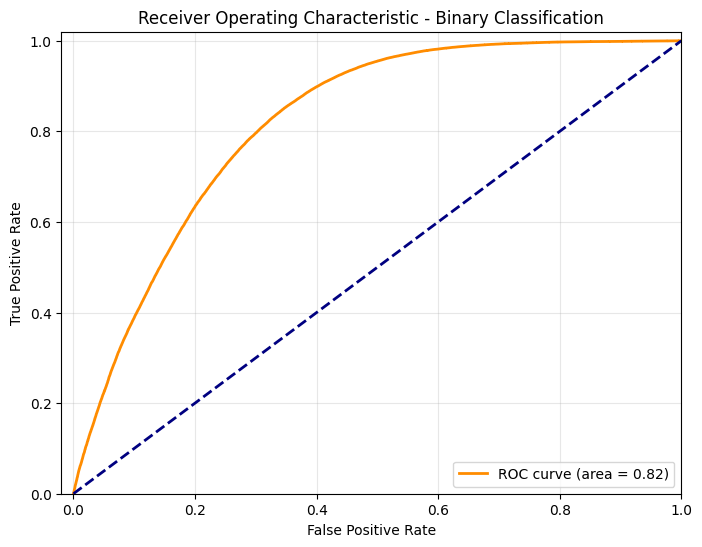

In [19]:
# Calculate AUROC and get ROC curve data
auroc, fpr, tpr, thresholds = calculate_auroc_with_curve(
    transmil_model, transmil_dataloader, device, n_classes=2
)

# Plot ROC curve
plot_roc_binary(fpr, tpr, auroc)


In [28]:
def extract_predictions(model, dataloader, device, threshold=0.7):
    """ Extracts predictions from the model.

    Args:
        model (nn.Module): Trained TransMIL model.
        dataloader (DataLoader): Dataloader for the dataset.
        device (torch.device): Device (CPU or GPU).
        threshold (float): Probability threshold for binary classification.

    Returns:
        predictions (list): List of tuples (image_path, predicted_label, predicted_probability).
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            X_batch = X_batch.to(device, non_blocking=True)
            logits, Y_prob, Y_hat, attn, _ = model(X_batch)

            # Convert logits to probabilities
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = (probs[:, 1] >= threshold).astype(int)  # Apply threshold for classification

            # Store original indices along with predictions
            for i in range(X_batch.size(0)):
                original_idx = batch_idx * X_batch.size(0) + i  # Compute the original index
                predictions.append((original_idx, preds[i], probs[i]))

    # Debugging: Count and display the number of tumor and non-tumor predictions
    num_tumor = sum(1 for _, pred, _ in predictions if pred == 1)
    num_non_tumor = sum(1 for _, pred, _ in predictions if pred == 0)
    print(f"Number of Tumor tiles: {num_tumor}")
    print(f"Number of Non-Tumor tiles: {num_non_tumor}")

    return predictions

# Example usage:
predictions = extract_predictions(transmil_model, transmil_dataloader, device, threshold=0.9)
print(f"Total Predictions Extracted: {len(predictions)}")


ValueError: not enough values to unpack (expected 5, got 4)

In [21]:
def extract_predictions_with_attention(model, dataloader, device, dataset, threshold=0.7, top_k=1):
    """ 
    Extracts predictions and attention scores from the model to identify high-risk tiles.

    Args:
        model (nn.Module): Trained TransMIL model.
        dataloader (DataLoader): Dataloader for the dataset.
        device (torch.device): Device (CPU or GPU).
        dataset (WSIDataset): The dataset instance to map indices to image paths.
        threshold (float): Probability threshold for binary classification.
        top_k (int): Number of top tiles to consider as high-risk per batch.

    Returns:
        predictions (list): List of tuples (image_path, predicted_label, predicted_probability, high_risk_tile_indices).
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            X_batch = X_batch.to(device, non_blocking=True)
            
            # Forward pass with attention
            logits, Y_prob, Y_hat, attns = model(X_batch,return_attn=True)
            
            # Convert logits to probabilities
            probs = torch.softmax(logits, dim=1).cpu().numpy()  # [B, 2]
            preds = (probs[:, 1] >= threshold).astype(int)  # Binary classification

            # Process attention
            # Assuming attns is a tuple: (attn1, attn2)
            # We'll use attn2 (from the last TransLayer) for higher-level attention
            attn_layer = attns[1]  # attns[0] is from layer1, attns[1] from layer2
            # attn_layer shape: [B, heads, seq_len, seq_len]

            # Extract attention from CLS token to each patch token
            # CLS token is at index 0
            # Exclude the CLS token itself (columns 1 to end)
            cls_to_patches = attn_layer[:, :, 0, 1:]  # [B, heads, N]
            cls_to_patches_mean = cls_to_patches.mean(dim=1)  # [B, N]

            # Identify top-k tiles with highest attention weights
            topk_values, topk_indices = torch.topk(cls_to_patches_mean, top_k, dim=1)  # Both [B, top_k]

            # Store predictions along with high-risk tile indices
            for i in range(X_batch.size(0)):
                original_idx = batch_idx * dataloader.batch_size + i
                if original_idx >= len(dataset):
                    continue  # Skip if out of range due to drop_last=False
                img_path = dataset.image_paths[original_idx]
                predicted_label = preds[i]
                predicted_prob = probs[i, 1]
                high_risk_tiles = topk_indices[i].cpu().numpy().tolist()  # List of tile indices
                predictions.append((img_path, predicted_label, predicted_prob, high_risk_tiles))

    # Debugging: Count and display the number of tumor and non-tumor predictions
    num_tumor = sum(1 for _, pred, _, _ in predictions if pred == 1)
    num_non_tumor = sum(1 for _, pred, _, _ in predictions if pred == 0)
    print(f"Number of Tumor samples: {num_tumor}")
    print(f"Number of Non-Tumor samples: {num_non_tumor}")

    return predictions



In [38]:
predictions = extract_predictions_with_attention(
    model=transmil_model,
    dataloader=transmil_dataloader,
    device=device,
    dataset=dataset,
    threshold=0.8,  # Adjust threshold as needed
    top_k=1  # Number of top tiles to consider as high-risk
)
print(f"Total Predictions Extracted: {len(predictions)}")


Number of Tumor samples: 13592
Number of Non-Tumor samples: 206432
Total Predictions Extracted: 220024


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Step 1: Generate feature_indices
# Assuming image_dataset is an instance of WSIDataset (which contains original images)
feature_indices = list(range(len(transmil_dataset)))

# Step 2: Define the function to visualize clustered tiles
def visualize_clustered_tiles(predictions, feature_indices, image_dataset, num_tiles=5, cluster_label=1):
    """ Visualizes the original tiles corresponding to clustered features.

    Args:
        predictions (list): List of tuples (original_idx, predicted_label, predicted_probability).
        feature_indices (list): List of feature indices corresponding to predictions.
        image_dataset (WSIDataset): Dataset returning image paths.
        num_tiles (int): Number of tiles to visualize.
        cluster_label (int): The cluster label to visualize (1 for tumor, 0 for non-tumor).
    """
    # Filter predictions by the specified cluster
    filtered_predictions = [(original_idx, pred, prob) for (original_idx, pred, prob) in predictions if pred == cluster_label]
    print(f"Number of tiles with cluster_label={cluster_label}: {len(filtered_predictions)}")
    
    # If there are fewer tiles than requested, adjust num_tiles to available tiles
    num_tiles = min(num_tiles, len(filtered_predictions))
    
    # Randomly select tiles to visualize
    tiles_to_visualize = random.sample(filtered_predictions, num_tiles)
    
    cols = min(num_tiles, 5)
    rows = (num_tiles + cols - 1) // cols  # Calculate rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    
    # Ensure axes is always iterable
    if num_tiles == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.flatten()  # Flatten in case of a single row

    for idx, (original_idx, pred, prob) in enumerate(tiles_to_visualize):
        # Convert original_idx to a Python integer
        original_idx = original_idx.item() if isinstance(original_idx, torch.Tensor) else original_idx
        
        # Use original_idx to get the corresponding image path
        img_path = image_dataset.image_paths[original_idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        axes[idx].imshow(image)
        axes[idx].axis('off')
        label = 'Tumor' if cluster_label == 1 else 'Not Tumor'
        color = 'red' if cluster_label == 1 else 'green'
        prob_display = prob[1] if cluster_label == 1 else prob[0]
        axes[idx].set_title(f"{label}\nProb: {prob_display:.2f}", color=color, fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.show()

# Visualize 5 tumor tiles
visualize_clustered_tiles(predictions, feature_indices, dataset, num_tiles=5, cluster_label=1)

# Visualize 5 non-tumor tiles
visualize_clustered_tiles(predictions, feature_indices, dataset, num_tiles=5, cluster_label=0)

Number of samples with cluster_label=1: 13592
Total high-risk tiles: 13592


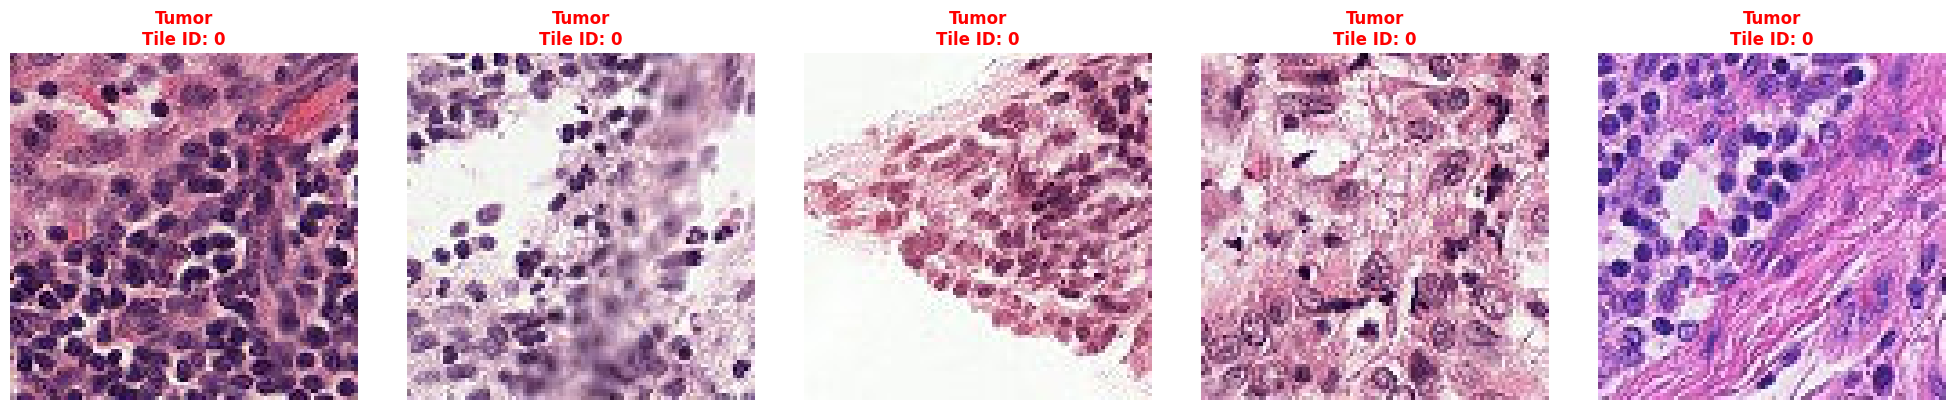

Number of samples with cluster_label=0: 206432
Total high-risk tiles: 206432


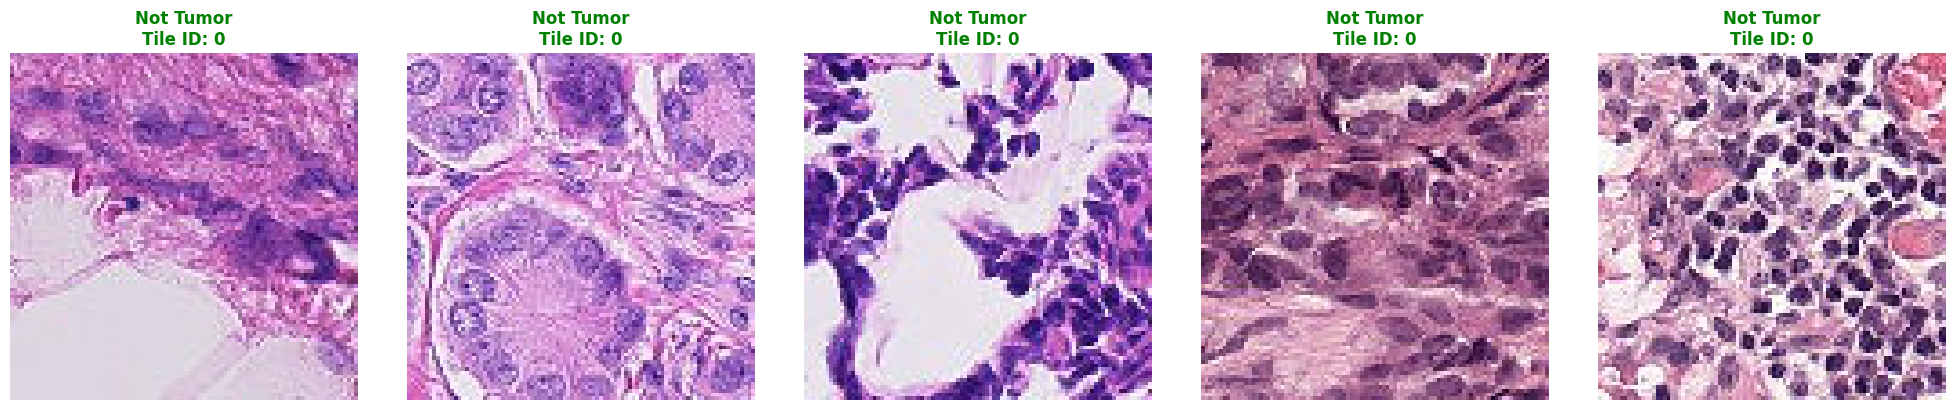

In [39]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def visualize_high_risk_tiles(predictions, dataset, num_tiles=5, cluster_label=1):
    """ 
    Visualizes high-risk tiles based on predictions.

    Args:
        predictions (list): List of tuples (image_path, predicted_label, predicted_probability, high_risk_tile_indices).
        dataset (WSIDataset): The dataset instance to map indices to image paths.
        num_tiles (int): Number of tiles to visualize per cluster.
        cluster_label (int): The cluster label to visualize (1 for tumor, 0 for non-tumor).
    """
    # Filter predictions by the specified cluster
    filtered_predictions = [
        (img_path, pred, prob, high_risk_tiles) 
        for (img_path, pred, prob, high_risk_tiles) in predictions 
        if pred == cluster_label
    ]
    print(f"Number of samples with cluster_label={cluster_label}: {len(filtered_predictions)}")

    # Collect unique high-risk tiles
    high_risk_tiles = []
    for img_path, _, _, tile_indices in filtered_predictions:
        for tile_idx in tile_indices:
            high_risk_tiles.append((img_path, tile_idx))

    print(f"Total high-risk tiles: {len(high_risk_tiles)}")

    # If there are fewer tiles than requested, adjust num_tiles
    num_tiles = min(num_tiles, len(high_risk_tiles))

    if num_tiles == 0:
        print(f"No high-risk tiles found for cluster_label={cluster_label}.")
        return

    # Randomly select tiles to visualize
    tiles_to_visualize = random.sample(high_risk_tiles, num_tiles)

    cols = min(num_tiles, 5)
    rows = (num_tiles + cols - 1) // cols  # Calculate rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    # Ensure axes is always iterable
    if num_tiles == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.flatten()  # Flatten in case of a single row

    for idx, (img_path, tile_idx) in enumerate(tiles_to_visualize):
        # Load the image
        image = Image.open(img_path).convert('RGB')
        
        # Assuming tile indexing corresponds to some spatial division, visualize the entire image or extract the specific tile
        # Here, we'll display the whole image with the tile index in the title.
        # For actual tile visualization, you need to know the spatial arrangement.

        # Placeholder: Display the whole image with the tile index in the title
        axes[idx].imshow(image)
        axes[idx].axis('off')
        label = 'Tumor' if cluster_label == 1 else 'Not Tumor'
        color = 'red' if cluster_label == 1 else 'green'
        axes[idx].set_title(f"{label}\nTile ID: {tile_idx}", color=color, fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_high_risk_tiles(predictions, dataset, num_tiles=5, cluster_label=1)  # For Tumor
visualize_high_risk_tiles(predictions, dataset, num_tiles=5, cluster_label=0)  # For Non-Tumor


In [36]:
def get_model_predictions(model, dataloader, device):
    """
    Returns:
        all_probs (ndarray): Probability predictions from the model of shape [N, 2].
        all_labels (ndarray): Ground-truth or pseudo labels of shape [N].
    """
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device, non_blocking=True)
            logits, Y_prob, _, _, _ = model(X_batch)  
            # Y_prob: shape = [batch_size, 2] for binary classification

            # Collect probabilities and labels
            all_probs.append(Y_prob.cpu())    # Move from GPU to CPU
            all_labels.append(y_batch.cpu())  # Move labels to CPU as well

    # Concatenate all batches
    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    return all_probs, all_labels


In [37]:
# 1) Get the predictions from TransMIL
all_probs, all_labels = get_model_predictions(transmil_model, transmil_dataloader, device)

# 2) Optionally compute AUROC here (if you want consistency):
from sklearn.metrics import roc_auc_score

#auroc_score = roc_auc_score(all_labels, all_probs[:, 1])  # Probability of class=1 (tumor)
#print(f"AUROC: {auroc_score:.4f}")


ValueError: not enough values to unpack (expected 5, got 4)

In [34]:
import matplotlib.pyplot as plt

# Filter probabilities for tumor vs. non-tumor
probs_tumor = all_probs[all_labels == 1, 1]       # Probability of class=1 for tumor-labeled samples
probs_nontumor = all_probs[all_labels == 0, 1]    # Probability of class=1 for non-tumor-labeled samples

# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(probs_tumor, bins=20, alpha=0.5, label='Tumor', color='red')
plt.hist(probs_nontumor, bins=20, alpha=0.5, label='Non-Tumor', color='green')
plt.xlabel("Predicted Probability of Tumor")
plt.ylabel("Count")
plt.legend()
plt.title(f"Distribution of Predicted Tumor Probabilities\n(AUROC = {auroc_score:.2f})")
plt.show()


NameError: name 'all_probs' is not defined